In [1]:
import logging
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from utils import view_sample_graph, get_input_files
from rich import print

%load_ext rich
%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

pd.set_option("display.max_columns", None)


## Load data

### Submissions

In [ ]:
submission_columns_ = [
    "author",
    "created_utc",
    "domain",
    "id",
    "is_self",
    "num_comments",
    "score",
    "selftext",
    "subreddit",
    "subreddit_id",
    "subreddit_subscribers",
    "title",
    "url",
    "downs",
    "ups",
]

mcgill_submissions = get_input_files("mcgill", type="submissions").read()[
    submission_columns_
]
waterloo_submissions = get_input_files("uwaterloo", type="submissions").read()[
    submission_columns_
]


INFO:DataLoader:File mcgill_submissions.zst already exists
INFO:DataLoader:File uwaterloo_submissions.zst already exists


### Comments

In [45]:
comments_columns_ = [
    "body",
    "name",
    "link_id",
    "parent_id",
    "downs",
    "subreddit",
    "score",
    "ups",
    "author",
    "created_utc",
    "permalink",
]


mcgill_comments = get_input_files("mcgill", type="comments").read()[comments_columns_]
waterloo_comments = get_input_files("uwaterloo", type="comments").read()[
    comments_columns_
]

mcgill_comments = mcgill_comments[
    ~mcgill_comments["author"].isin(["[deleted]", "[removed]"])
]
waterloo_comments = waterloo_comments[
    ~waterloo_comments["author"].isin(["[deleted]", "[removed]"])
]


INFO:DataLoader:File mcgill_comments.zst already exists
INFO:DataLoader:File uwaterloo_comments.zst already exists


In [49]:
mcgill_comments

,body,name,link_id,parent_id,downs,subreddit,score,ups,author,created_utc,permalink
0,yeah it is working !!!yeah!!,t1_c0k49nz,t3_aypo9,t3_aypo9,0.0,mcgill,1,1.0,david_a_garcia,1265513329,NaN
1,so how are classes at mcgill?,t1_c0k5eqa,t3_aypo9,t3_aypo9,0.0,mcgill,1,1.0,david_a_garcia,1265576681,NaN
2,it's getting kinda hard now...midterms next we...,t1_c0kd9oh,t3_aypo9,t1_c0k5eqa,0.0,mcgill,1,1.0,david_a_garcia,1265871720,NaN
3,Most of us hang out in /r/montreal,t1_c0tj3fg,t3_aypo9,t3_aypo9,0.0,mcgill,3,3.0,iorgfeflkd,1278301431,NaN
7,I think you should join your student societies...,t1_c1juj2w,t3_fzkkf,t3_fzkkf,0.0,mcgill,5,5.0,vozerek,1299596858,NaN
...,...,...,...,...,...,...,...,...,...,...,...
475758,"Hello, it looks like you're asking a question ...",t1_j2fopqk,t3_1005t5r,t3_1005t5r,NaN,mcgill,1,NaN,AutoModerator,1672527103,/r/mcgill/comments/1005t5r/mgcr_222_with_prof_...
475759,"I do not pay my tuition, but I manage to pay f...",t1_j2fssqv,t3_za64op,t1_j2fi6lz,NaN,mcgill,1,NaN,18degreescelcius,1672529020,/r/mcgill/comments/za64op/how_are_people_able_...
475760,I think the best thing you can do at this poin...,t1_j2ftc5k,t3_zvz61m,t3_zvz61m,NaN,mcgill,2,NaN,GoddamnWateryOatmeal,1672529266,/r/mcgill/comments/zvz61m/looking_for_math_und...
475761,I'm sure someone in your field could give a fa...,t1_j2ftmub,t3_zzxrsd,t3_zzxrsd,NaN,mcgill,3,NaN,necrolancerlol,1672529399,/r/mcgill/comments/zzxrsd/untraditional_underg...


## Create bipartite graph

In [80]:
def create_bipartite_graph(df: pd.DataFrame):
    B = nx.Graph()

    users = df["author"].unique()
    posts = df["link_id"].unique()

    B.add_nodes_from(users, bipartite=0)
    B.add_nodes_from(posts, bipartite=1)

    edges = df[["author", "link_id"]].apply(tuple, axis=1).tolist()

    B.add_edges_from(edges)

    if nx.is_bipartite(B):
        user_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
        post_nodes = set(B) - user_nodes

    return user_nodes, post_nodes, B


def project_bipartite_graph(B, nodes):
    return nx.bipartite.projected_graph(B, nodes)

In [81]:
mcgill_user_nodes, mcgill_post_nodes, mcgill_B = create_bipartite_graph(mcgill_comments)
waterloo_user_nodes, waterloo_post_nodes, waterloo_B = create_bipartite_graph(waterloo_comments)

In [83]:
mcgill_user_graph = project_bipartite_graph(mcgill_B, mcgill_user_nodes)
waterloo_user_graph = project_bipartite_graph(waterloo_B, waterloo_user_nodes)

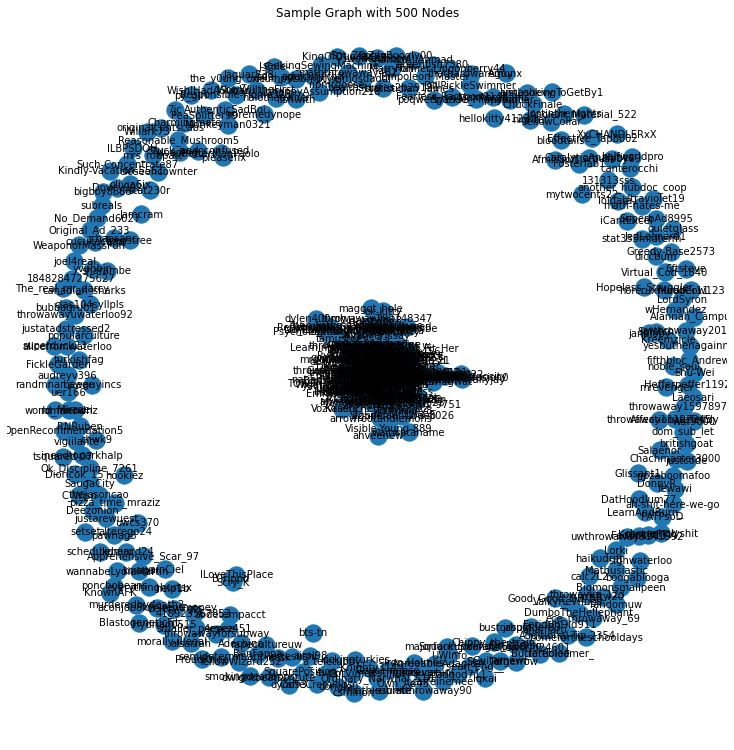

In [84]:
view_sample_graph(waterloo_user_graph, 500)